In [2]:
import pandas as pd
import io
import requests
import sklearn
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
%pylab inline
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import seaborn as sns
#hide warnings
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Adult dataset

In [5]:
adult_income_df = pd.read_csv('./data/adult_income.csv')
# If reading it in
adult_income_df.drop('Unnamed: 0', axis=1, inplace=True)
#transform income into more than 50k less than 50k
income_transformed =  adult_income_df['income_bracket'].apply(lambda x: 0 if x == ' <=50K' else 1)
adult_income_df['income_bracket'] =income_transformed

In [10]:
def one_hot_text_encoder(df, text_cols=['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'sex', 'native_country', 'race']):
    for col in text_cols:
        # Get k-1 columns
        one_hot_df = pd.get_dummies(df[col], drop_first=True)
        df = df.drop(col, axis=1)
        df = pd.concat([df, one_hot_df], axis=1)
    return df

In [11]:
transformed_adult_income_df = one_hot_text_encoder(adult_income_df)

X_transformed_adult_income_df = transformed_adult_income_df.iloc[:, transformed_adult_income_df.columns != 'income_bracket']
Y_transformed_adult_income_df = transformed_adult_income_df['income_bracket']

In [13]:
transformed_adult_income_df.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income_bracket,Federal-gov,Local-gov,Never-worked,...,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia,Asian-Pac-Islander,Black,Other,White
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Banking Dataset

In [16]:
banking_df = pd.read_csv('data/bank-full.csv', delimiter =';')

# transform y into 1 and 0 
banking_df['y'] = banking_df['y'].apply(lambda x: 1 if x =='yes' else 0)

banking_text_cols = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'poutcome', 'default']
transformed_banking_df = one_hot_text_encoder(banking_df, banking_text_cols)

X_transformed_banking_df = transformed_banking_df.iloc[:, transformed_banking_df.columns != 'y']
Y_transformed_banking_df = transformed_banking_df['y']

# Learning Curves

In [25]:
# Taken from - https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=3,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 20)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label=str(cv) +"x Cross-validation testing score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/jonathanhilgart/.pyenv/versions/omscs_ml/lib/python3.6/site-packages/matplotlib/pyplot.py'>

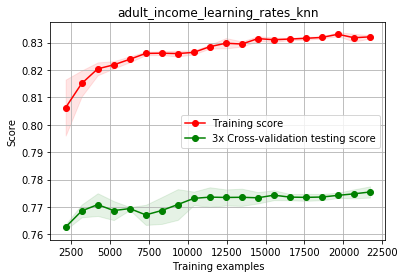

In [26]:
plot_learning_curve(KNeighborsClassifier(), 'adult_income_learning_rates_knn',                    
                    X_transformed_adult_income_df, Y_transformed_adult_income_df)

<module 'matplotlib.pyplot' from '/Users/jonathanhilgart/.pyenv/versions/omscs_ml/lib/python3.6/site-packages/matplotlib/pyplot.py'>

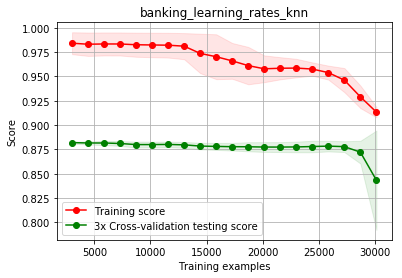

In [28]:
plot_learning_curve(KNeighborsClassifier(), 'banking_learning_rates_knn',                    
                    X_transformed_banking_df, Y_transformed_banking_df)

# Random Grid Search for best parameters

In [64]:

adult_trgX, adult_tstX, adult_trgY, adult_tstY = train_test_split(
    X_transformed_adult_income_df, Y_transformed_adult_income_df, test_size=0.3, random_state=0, 
    stratify=Y_transformed_adult_income_df)

banking_trgX, banking_tstX, banking_trgY, banking_tstY = train_test_split(
    X_transformed_banking_df, Y_transformed_banking_df, test_size=0.1, random_state=0, stratify=Y_transformed_banking_df)     


n_neighbors = [i for i in range(1, 30, 2)]

pipeA = Pipeline([('Scale', StandardScaler()),
                 ('KNN', KNeighborsClassifier(n_jobs=-1))]) 


pipeB = Pipeline([('Scale', StandardScaler()),                 
                 ('KNN',KNeighborsClassifier(n_jobs=-1))])


params = {'KNN__weights':['uniform','distance'],'KNN__algorithm':['auto'], 'KNN__n_neighbors':n_neighbors}


In [43]:
a_grid_search = GridSearchCV(pipeA, params, return_train_score=True, n_jobs = -1)
banking_grid_serach = GridSearchCV(pipeB, params, return_train_score=True, n_jobs=-1)

In [44]:
a_grid_search.fit(adult_trgX, adult_trgY)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('Scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'KNN__weights': ['uniform', 'distance'], 'KNN__algorithm': ['auto'], 'KNN__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [94]:
len(adult_trgX.columns)

100

In [45]:
a_grid_search.best_params_

{'KNN__algorithm': 'auto', 'KNN__n_neighbors': 19, 'KNN__weights': 'uniform'}

In [46]:
banking_grid_serach.fit(banking_trgX, banking_trgY)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('Scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'KNN__weights': ['uniform', 'distance'], 'KNN__algorithm': ['auto'], 'KNN__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [47]:
banking_grid_serach.best_params_

{'KNN__algorithm': 'auto', 'KNN__n_neighbors': 13, 'KNN__weights': 'distance'}

In [95]:
len(banking_trgX.columns)

42

# Time how long it takes to train the best parameters found

In [58]:
#adult
%timeit KNeighborsClassifier(algorithm='auto', n_neighbors=19, weights='uniform', n_jobs=-1).fit(adult_trgX, adult_trgY)

183 ms ± 6.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [65]:
best_adult_knn = KNeighborsClassifier(algorithm='auto', n_neighbors=19, weights='uniform', n_jobs=-1).fit(adult_trgX, adult_trgY)

In [66]:
accuracy_score(best_adult_knn.predict(adult_tstX), adult_tstY)

0.7976665643229967

In [96]:
precision_recall_fscore_support(best_adult_knn.predict(adult_tstX), adult_tstY)

(array([0.97897291, 0.22576531]),
 array([0.79953765, 0.77292576]),
 array([0.8802036 , 0.34945706]),
 array([3028,  229]))

In [59]:
#banking
%timeit KNeighborsClassifier(algorithm='auto', n_neighbors=19, weights='uniform', n_jobs=-1).fit(banking_trgX, banking_trgY)

78.9 ms ± 4.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [67]:
best_banking_knn = KNeighborsClassifier(algorithm='auto', n_neighbors=13, weights='distance', n_jobs=-1).fit(banking_trgX, banking_trgY)



In [68]:
accuracy_score(best_banking_knn.predict(banking_tstX), banking_tstY)

0.8827952233524989

In [97]:
precision_recall_fscore_support(best_banking_knn.predict(banking_tstX), banking_tstY)

(array([0.9679439 , 0.24007561]),
 array([0.90578861, 0.49803922]),
 array([0.93583535, 0.32397959]),
 array([4267,  255]))

# Learning rate as function of K (# neighbors)

In [79]:
def plot_tree_versus_training_test_score_for_classifier(all_x, all_y, 
                                                              max_depth_iterations=[_ for _ in range(1,25,2)], 
                                                              cv_iterations=3, 
                                                              test_size=.30,
                                                              ):
    # Take in a classifier and return a dataframe of learning rate metrics
    
    depth = []
    training_scores = {}
    testing_scores = {}
    
    training_precision_scores = {}
    testing_precision_scores = {}
    
    training_recall_scores = {}
    testing_recall_scores = {}
    
    training_f1score_scores = {}
    testing_f1score_scores = {}
    
    training_mean_score = []
    testing_mean_score = []
    training_mean_precision = []
    testing_mean_precision = []
    training_mean_recall= [] 
    testing_mean_recall = []
    training_mean_f1score = []
    testing_mean_f1score = []
    
    counter = 0
    for k in max_depth_iterations:
        print(f"i={k}")
        for cv in range(cv_iterations):
            trgX, tstX, trgY, tstY = train_test_split(
                all_x, all_y, test_size=test_size, random_state=0
            )
            
            pipe = Pipeline([('Scale',StandardScaler()),
                     ('KNN', KNeighborsClassifier(n_jobs=-1, n_neighbors=k))]) 
            pipe.fit(trgX, trgY)
            
            training_predictions = pipe.predict(trgX)
            testing_predictions = pipe.predict(tstX)

            if cv == 0:
                training_scores[k] = [accuracy_score(training_predictions, trgY)]
                testing_scores[k] = [accuracy_score(testing_predictions, tstY)]
                
                precision_train, recall_train, fscore_train, support_train = precision_recall_fscore_support(training_predictions, trgY)
                precision_test, recall_test, fscore_test, support_test = precision_recall_fscore_support(testing_predictions, tstY)
                # precisiion recall f1score
                training_precision_scores[k] = [precision_train]
                training_recall_scores[k] = [recall_train]
                training_f1score_scores[k] = [fscore_train]
                
                testing_precision_scores[k] = [precision_test]
                testing_recall_scores[k] = [recall_test]
                testing_f1score_scores[k] = [fscore_test]
                
                
            elif cv < cv_iterations-1:
                training_scores[k].append(accuracy_score(training_predictions, trgY))
                testing_scores[k].append(accuracy_score(testing_predictions, tstY))
                
                precision_train, recall_train, fscore_train, support_train = precision_recall_fscore_support(training_predictions, trgY)
                precision_test, recall_test, fscore_test, support_test = precision_recall_fscore_support(testing_predictions, tstY)
                
                testing_precision_scores[k].append(precision_test)
                testing_recall_scores[k].append(recall_test)
                testing_f1score_scores[k].append(fscore_test)
                
                training_precision_scores[k].append(precision_train)
                training_recall_scores[k].append(recall_train)
                training_f1score_scores[k].append(fscore_train)
                
            else:
                training_scores[k].append(accuracy_score(training_predictions, trgY))
                testing_scores[k].append(accuracy_score(testing_predictions, tstY))
                
                precision_train, recall_train, fscore_train, support_train = precision_recall_fscore_support(training_predictions, trgY)
                precision_test, recall_test, fscore_test, support_test = precision_recall_fscore_support(testing_predictions, tstY)
                
                testing_precision_scores[k].append(precision_test)
                testing_recall_scores[k].append(recall_test)
                testing_f1score_scores[k].append(fscore_test)
                
                training_precision_scores[k].append(precision_train)
                training_recall_scores[k].append(recall_train)
                training_f1score_scores[k].append(fscore_train)
                # add the mean scores
                
                training_mean_score.append(np.mean(training_scores[k]))
                testing_mean_score.append(np.mean(testing_scores[k]))
                
                training_mean_precision.append(np.mean(training_precision_scores[k]))
                testing_mean_precision.append(np.mean(testing_precision_scores[k]))
                
                training_mean_recall.append(np.mean(training_recall_scores[k]))
                testing_mean_recall.append(np.mean(testing_recall_scores[k]))
                
                training_mean_f1score.append(np.mean(training_f1score_scores[k]))
                testing_mean_f1score.append(np.mean(testing_f1score_scores[k]))
                
                
            
    results_df = pd.DataFrame.from_dict({
        'K':max_depth_iterations,
        'training_cv_{}x_score'.format(cv_iterations): training_mean_score,
        'testing_cv_{}x_score'.format(cv_iterations): testing_mean_score,
        'training_cv_{}x_mean_precision'.format(cv_iterations): training_mean_precision,
        'testing_cv_{}x_mean_precision'.format(cv_iterations): testing_mean_precision,
        'training_cv_{}x_mean_recall'.format(cv_iterations) : training_mean_recall,
        'testing_cv_{}x_mean_recall'.format(cv_iterations): testing_mean_recall,
        'training_cv_{}x_mean_f1score'.format(cv_iterations) : training_mean_f1score,
        'testing_cv_{}x_mean_f1score'.format(cv_iterations): testing_mean_f1score}
    )
    return results_df
        
    
    

In [80]:
adult_knn_results_df = plot_tree_versus_training_test_score_for_classifier(X_transformed_adult_income_df, 
                                                                      Y_transformed_adult_income_df)

i=1
i=3
i=5
i=7
i=9
i=11
i=13
i=15
i=17
i=19
i=21
i=23


Text(0, 0.5, 'Percent')

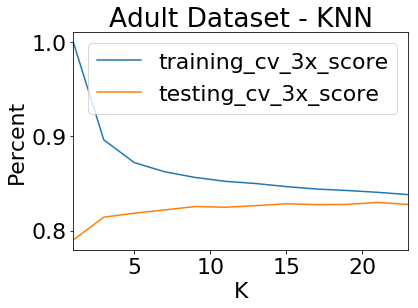

In [92]:
adult_knn_results_df.plot(x='K', y=['training_cv_3x_score','testing_cv_3x_score'], kind='line' )
plt.title('Adult Dataset - KNN')
plt.ylabel('Percent')

In [84]:
banking_knn_results_df = plot_tree_versus_training_test_score_for_classifier(X_transformed_banking_df, 
                                                                      Y_transformed_banking_df)

i=1
i=3
i=5
i=7
i=9
i=11
i=13
i=15
i=17
i=19
i=21
i=23


Text(0, 0.5, 'Percent')

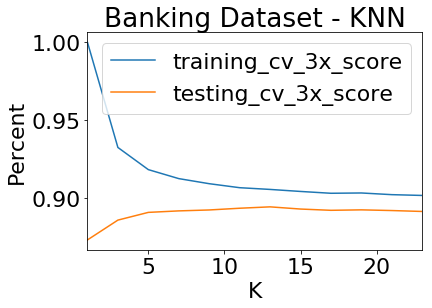

In [91]:
banking_knn_results_df.plot(x='K', y=['training_cv_3x_score','testing_cv_3x_score'], kind='line' )
plt.title('Banking Dataset - KNN')
plt.ylabel('Percent')

# Confusion Matrix

In [86]:
def cm_analysis(y_true, y_pred, labels, plot_title, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(plot_title)
    plt.rcParams.update({'font.size': 22})
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

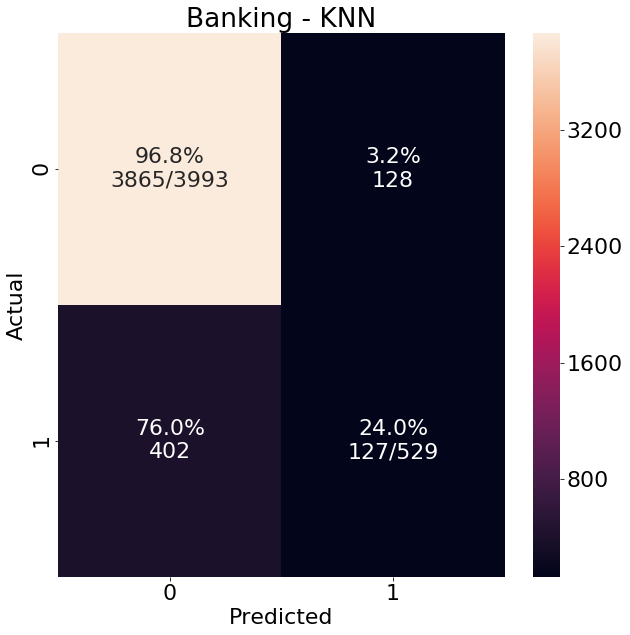

In [90]:
cm_analysis(banking_tstY, best_banking_knn.predict(banking_tstX), best_banking_knn.classes_, 'Banking - KNN')


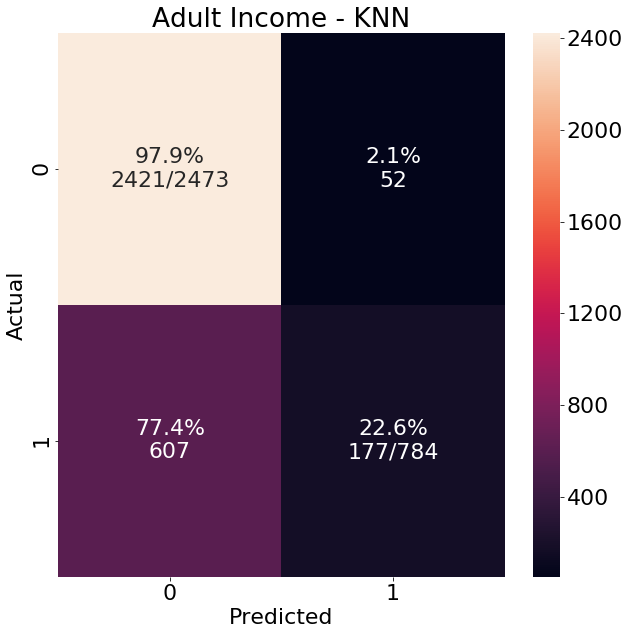

In [89]:
cm_analysis(adult_tstY, best_adult_knn.predict(adult_tstX), best_adult_knn.classes_, 'Adult Income - KNN')
